# Reproduction of the Stiliadis

## Reproduction of Figure 4 of Stiliadis 

This is the reproduction of the figure 4 from Stiliadis without running PIM after the matching process. Figure 4 plots the average delay of the packets in 16 times 16 packet switch under the client-server traffic model. For the client-server model, the paper assumed that the server takes to 4 input/output ports and the client takes 12 input/output ports. Then, the server allocates 95 percents of its bandwidth to the client output ports, 5 percent to other server ports. The client allocates 40 percent of its bandwidth to the server output ports and 60 percent of its bandwidth to the client output ports. `ClientServerInputGenerator` generates the traffic in such way.

We increased the load to each input port from 0.05 to 1. Note that if the packet gets immediately queued to the output port, then the delay is 0.

The authors did not mention up until when they simulated the switching. For our experiment, we sent total of 10,000 packets.

This version of the switch faithfully generates the plot in the original paper. It takes couple of minutes to generate a plot. From my Macbook Pro, it took 4 minutes to finish the simulation.


In [23]:
%matplotlib inline
# Automatically reload modules to pick up changes.
# See https://ipython.org/ipython-doc/3/config/extensions/autoreload.html
%load_ext autoreload
%autoreload 2

from lib.client_server_input_generator import ClientServerInputGenerator
from lib.pim import PimSwitch
from lib.statistical import StatisticalSwitch
from lib.wpim import WPimSwitch
from lib.plot import draw_plot
import numpy as np
from tqdm import tnrange, tqdm_notebook

loads = np.linspace(0.05, 0.95, 19)
credit = np.zeros((16, 16))

# 95% of server traffic distributed to 12 clients, 5% to other servers
# 40% of client traffic goes to 4 servers. 60% goes to clients

# Server credits
for i in range(4):
    for j in range(16):
        if j < 4 and j != i:
            credit[i][j] = 1000 * 0.05 / 3
        elif j >= 4:
            credit[i][j] = 1000 * 0.95 / 12

# Client credits
for i in range(4, 16):
    for j in range(16):
        if j < 4:
            credit[i][j] = 1000 * 0.1
        elif j >= 4 and j != i:
            credit[i][j] = 1000 * 0.6 / 11

total_run = 10000

delay_per_load = np.zeros((2, len(loads)))

for l, load in enumerate(tqdm_notebook(loads)):
    switches = [StatisticalSwitch(16, 16, credit), WPimSwitch(16, 16, credit, frame_length=1000)]
    for i, switch in enumerate(switches):
        gen = ClientServerInputGenerator(switch, L=load)
        gen.run(total_run)

        # Compute the average queueing delay of packets.
        delays = []
        for packet in switch.processed_packets:
            delays.append(packet.time_in_queue)

        average_delay = np.average(delays)
        delay_per_load[i][l] = average_delay

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


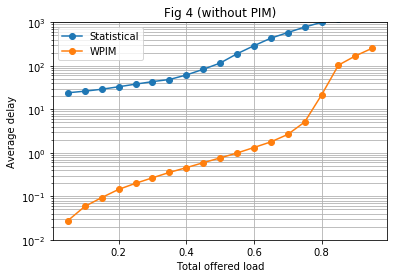

In [24]:
plt = draw_plot(loads, delay_per_load, ["Statistical", "WPIM"], scale="log", title="Fig 4 (without PIM)", xlabel="Total offered load", ylabel="Average delay", ylim=[10**(-2),1000])


<img src="FIG4.png" alt="Drawing" style="width: 400px;"/>

As you can see, it matches the original graph in the paper.

However, the original statistical matching paper mentions about running PIM after the matching process since it can only utilize 72% of the provided bandwidth. With this being enabled, the plot looks very different. We are not able to observe the delay under the smaller load on statistical matching.

In [25]:
delay_per_load_pim = np.zeros((2, len(loads)))

for l, load in enumerate(tqdm_notebook(loads)):
    switches = [StatisticalSwitch(16, 16, credit, run_pim_after=True), WPimSwitch(16, 16, credit, frame_length=1000, run_pim_after=True)]
    for i, switch in enumerate(switches):
        gen = ClientServerInputGenerator(switch, L=load)
        gen.run(total_run)

        # Compute the average queueing delay of packets.
        delays = []
        for packet in switch.processed_packets:
            delays.append(packet.time_in_queue)

        average_delay = np.average(delays)
        delay_per_load_pim[i][l] = average_delay



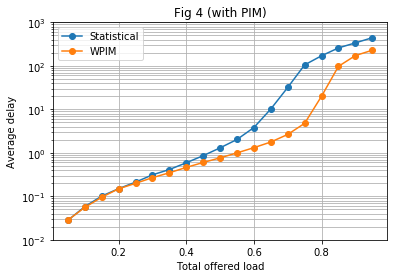

In [26]:
plt = draw_plot(loads, delay_per_load_pim, ["Statistical", "WPIM"], scale="log", title="Fig 4 (with PIM)", xlabel="Total offered load", ylabel="Average delay", ylim=[0.01,1000])


## Reproduction of Figure 5 of Stiliadis 

Again, this is the reproduction of figure 5 from Stiliadis without running PIM after the matching process. Figure 5 is the plot of the latency of the packets in the same client-server traffic model used in figure 4 but against the different number of iterations for the WPIM matching. 

This one also closely matches to the one in the paper.

In [27]:
delay_per_load_fig_5 = np.zeros((4, len(loads)))

for num_iter in range(1, 5):
    for l, load in enumerate(tqdm_notebook(loads)):
        switch = WPimSwitch(16, 16, credit, frame_length=1000, num_iteration=num_iter)
        gen = ClientServerInputGenerator(switch, L=load)
        gen.run(total_run)

        # Compute the average queueing delay of packets.
        delays = []
        for packet in switch.processed_packets:
            delays.append(packet.time_in_queue)

        average_delay = np.average(delays)
        delay_per_load_fig_5[num_iter - 1][l] = average_delay


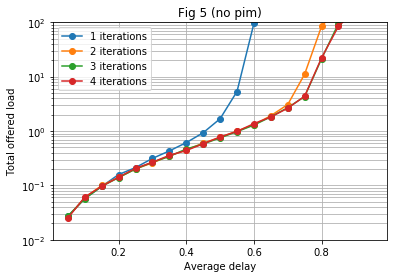

In [28]:
plt = draw_plot(loads, delay_per_load_fig_5, [str(i) + " iterations" for i in range(1, 5)], scale="log", title="Fig 5 (no pim)", xlabel="Average delay", ylabel="Total offered load", ylim=[0.01,100])

<img src="FIG5.png" alt="Drawing" style="width: 400px;"/>

The generated plot also closely matches to the original graph in the paper.

Here again, we re-ran the experiment with PIM at the end treatment. Now, it gives very different result.

In [29]:
delay_per_load_fig_5_pim = np.zeros((4, len(loads)))

for num_iter in range(1, 5):
    for l, load in enumerate(tqdm_notebook(loads)):
        switch = WPimSwitch(16, 16, credit, frame_length=1000, num_iteration=num_iter, run_pim_after=True)
        gen = ClientServerInputGenerator(switch, L=load)
        gen.run(total_run)

        # Compute the average queueing delay of packets.
        delays = []
        for packet in switch.processed_packets:
            delays.append(packet.time_in_queue)

        average_delay = np.average(delays)
        delay_per_load_fig_5_pim[num_iter - 1][l] = average_delay

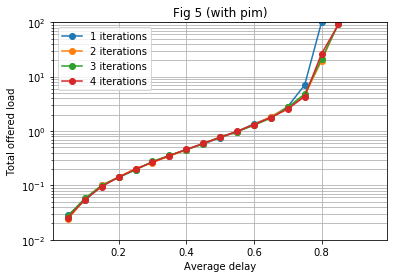

In [30]:
plt = draw_plot(loads, delay_per_load_fig_5_pim, [str(i) + " iterations" for i in range(1, 5)], scale="log", title="Fig 5 (with pim)", xlabel="Average delay", ylabel="Total offered load", ylim=[0.01,100])

## Reproduction of Figure 5 of Stiliadis 

Finally, this is the reproduction of figure 6 from Stiliadis without running PIM after the matching process. It plots the allocated bandwidth of the 4 times 4 switch under the different load on input ports. Every input port switches to the single output port but they are each assigned to 40, 30, 20 and 10 percent of the bandwidth.

As you can see, it does not follows the graph in the original paper.

In [31]:
from lib.output_contention_input_generator import OutputContentionInputGenerator

loads = np.linspace(0.05, 1, 19)
credit = np.array([[100, 0, 0, 0], [200, 0, 0, 0], [300, 0, 0, 0], [400, 0, 0, 0]])
credit_stat = np.array([[1], [2], [3], [4]])

data_fig6 = [np.zeros((4, len(loads))) for _ in range(3)]
total_run = 10000

for l, load in enumerate(loads):
    switches = [ WPimSwitch(4, 4, credit, frame_length=1000), PimSwitch(4, 4), StatisticalSwitch(4, 1, credit_stat, 10)]
    for i, switch in enumerate(switches):
        gen = OutputContentionInputGenerator(switch, load, 4, 0, [0, 1, 2, 3])
        gen.run(total_run)

        bandwidth_usage = switch.input_output_cnt[:, 0]
        normalized_bandwidth = bandwidth_usage / total_run

        for j in range(4):
            data_fig6[i][j][l] = normalized_bandwidth[j]


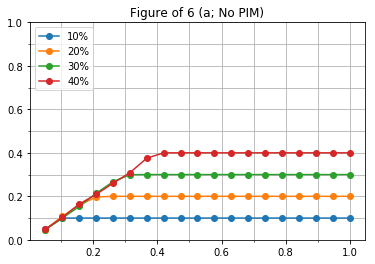

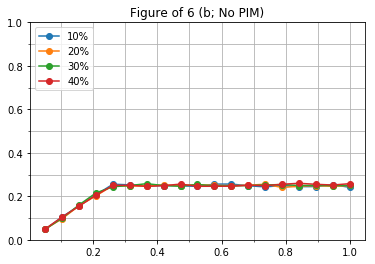

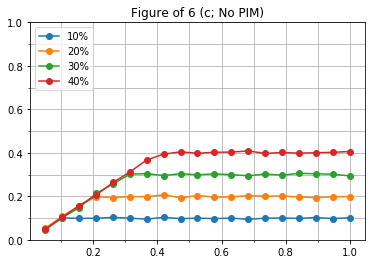

In [32]:
cs = ['a', 'b', 'c']
for i, d in enumerate(data_fig6):
    plt = draw_plot(loads, d, [str((j + 1) * 10) + "%" for j in range(4)], ylim=[0, 1], figure_index=i, spacing=0.1,
              title="Figure of 6 (" + cs[i] + "; No PIM)")
    plt.show()


<img src="FIG6.png" alt="Drawing" style="width: 800px;"/>

Note that without running PIM at the end, the simulated graph was different from the graph in the original paper.

It could only be reproduced by running PIM after the matching process. This makes sense because, without running PIM at the end, under the light load, the input port that is given 10 percent of the bandwidth would not be able to have 25 percent of the bandwidth.

In [33]:
loads = np.linspace(0.05, 1, 19)
credit = np.array([[100, 0, 0, 0], [200, 0, 0, 0], [300, 0, 0, 0], [400, 0, 0, 0]])
credit_stat = np.array([[1], [2], [3], [4]])

data_fig6_pim = [np.zeros((4, len(loads))) for _ in range(3)]
total_run = 10000

for l, load in enumerate(loads):
    switches = [ WPimSwitch(4, 4, credit, frame_length=1000, run_pim_after=True), PimSwitch(4, 4), StatisticalSwitch(4, 1, credit_stat, 10, run_pim_after=True)]
    for i, switch in enumerate(switches):
        gen = OutputContentionInputGenerator(switch, load, 4, 0, [0, 1, 2, 3])
        gen.run(total_run)

        bandwidth_usage = switch.input_output_cnt[:, 0]
        normalized_bandwidth = bandwidth_usage / total_run

        for j in range(4):
            data_fig6_pim[i][j][l] = normalized_bandwidth[j]



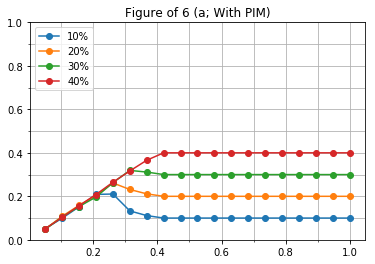

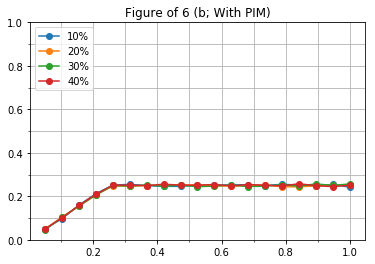

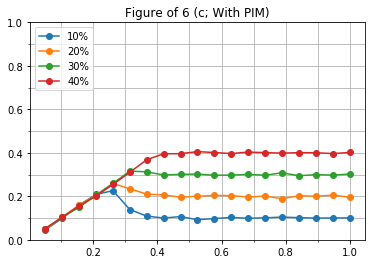

In [34]:
cs = ['a', 'b', 'c']
for i, d in enumerate(data_fig6_pim):
    plt = draw_plot(loads, d, [str((j + 1) * 10) + "%" for j in range(4)], ylim=[0, 1], figure_index=i, spacing=0.1,
              title="Figure of 6 (" + cs[i] + "; With PIM)")
    plt.show()